# Desafio 05 | SONDA
## Objetivo
O desafio consiste de implementar um algoritmo de Machine Learning para classificação binária, capaz de identificar se um cliente será perdido ou não.

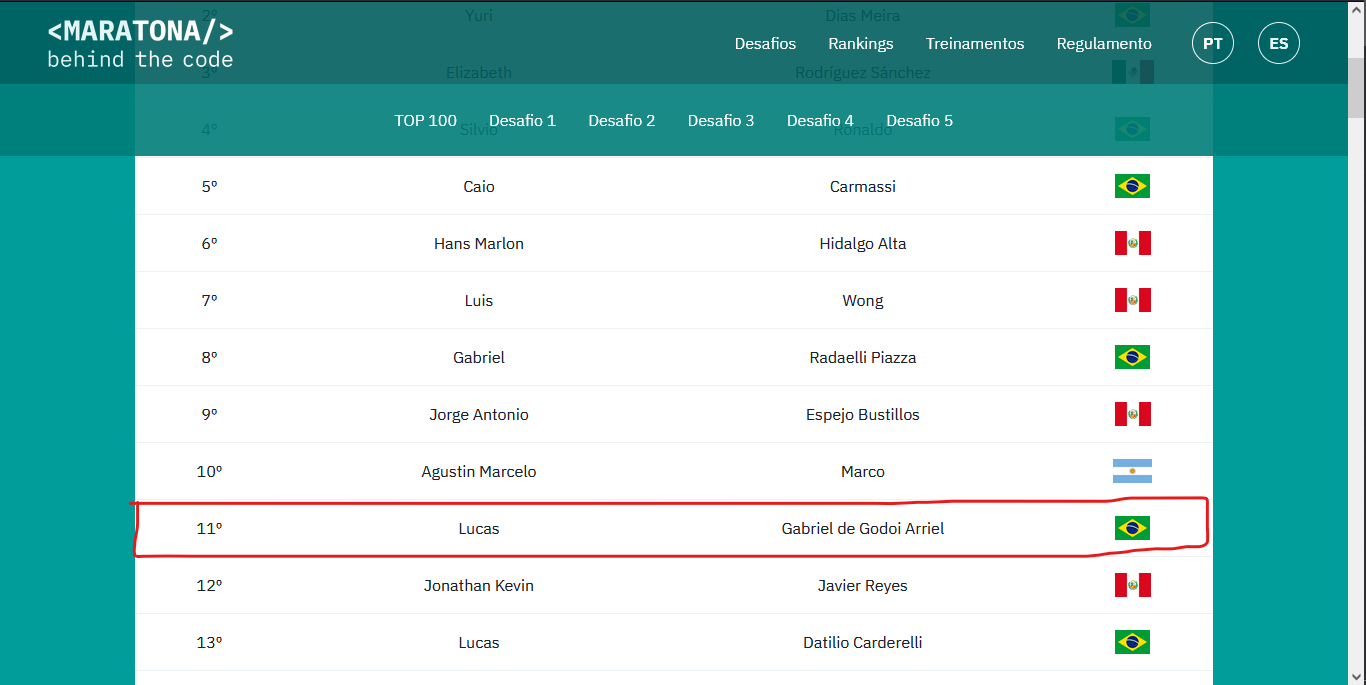

In [1]:
from PIL import Image
image = Image.open("Ranking11.png")
image

## Import das bibliotecas

In [102]:
!pip install dython

You should consider upgrading via the 'c:\users\lucas\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


In [40]:
from dython import nominal
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE, SMOTENC
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split, cross_validate, cross_val_score, StratifiedKFold, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, LabelEncoder

## Leitura e análise do dataset

In [2]:
df = pd.read_csv('dataset.csv')

In [ ]:
df['CHURN'].unique()

array(['No', 'Yes'], dtype=object)

In [ ]:
dfNa = df.dropna()

In [ ]:
dfteste = df.fillna(df.mode().iloc[0])

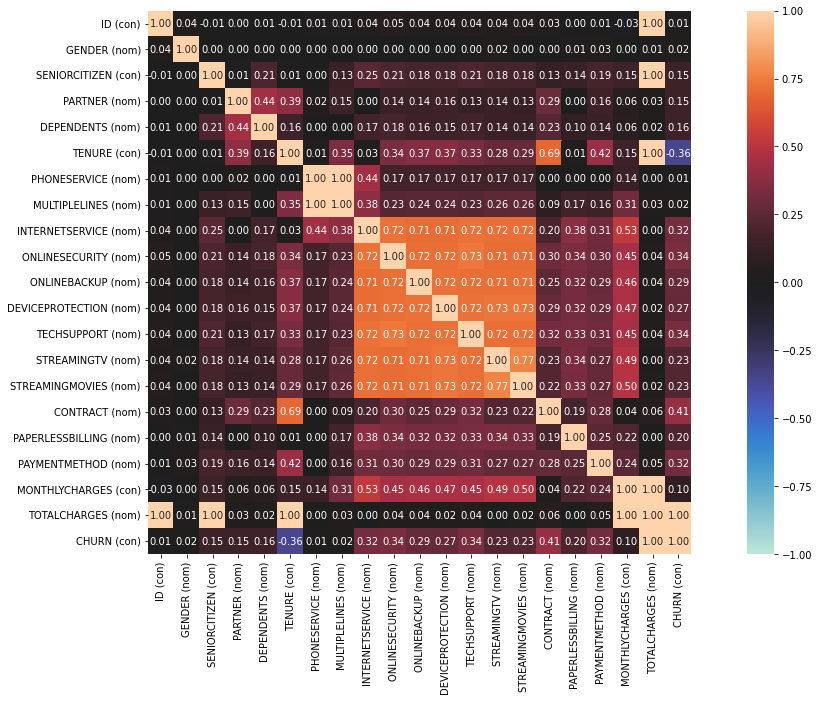

{'ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fdbd3bae510>,
 'corr':                         ID (con)  GENDER (nom)  ...  TOTALCHARGES (nom)  CHURN (con)
 ID (con)                1.000000      0.035375  ...            0.996530     0.008961
 GENDER (nom)            0.035375      1.000000  ...            0.009089     0.022519
 SENIORCITIZEN (con)    -0.012365      0.002486  ...            0.997288     0.152072
 PARTNER (nom)           0.000281      0.000000  ...            0.034902     0.149045
 DEPENDENTS (nom)        0.006547      0.000000  ...            0.015844     0.162725
 TENURE (con)           -0.010645      0.001318  ...            0.999518    -0.358111
 PHONESERVICE (nom)      0.009682      0.000000  ...            0.000000     0.009270
 MULTIPLELINES (nom)     0.010096      0.000000  ...            0.025011     0.021759
 INTERNETSERVICE (nom)   0.038531      0.000000  ...            0.000000     0.321874
 ONLINESECURITY (nom)    0.048862      0.002905  ...            0.

In [ ]:
nominal.associations(dfNa, figsize=(20,10), mark_columns=True)

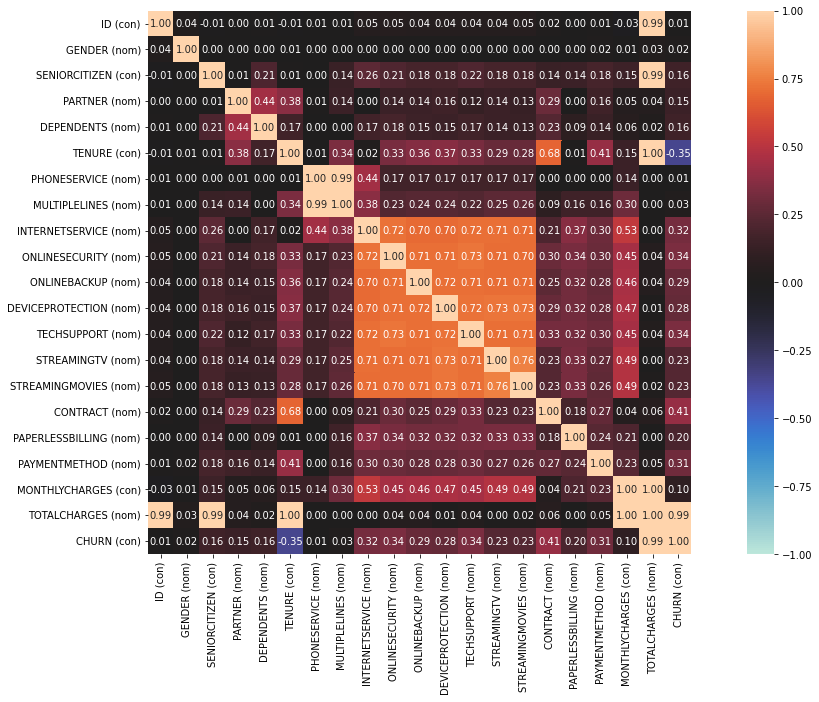

In [ ]:
nominal.associations(dfteste, figsize=(20,10), mark_columns=True);

Analisei a matriz e removi as que possuiam menos relações no total e com a coluna CHURN

In [3]:
class DropColumns(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        data = X.copy()
        return data.drop(labels=self.columns, axis='columns')

In [4]:
class DummyEstimator(BaseEstimator):
        def fit(self): pass
        def score(self): pass

## Distribuição das variáveis de treino e teste

In [4]:
X = df.drop('CHURN', axis=1, inplace=False)
y = df.CHURN

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 1)

In [6]:
unwanted_columns = ['ID', 'GENDER', 'SENIORCITIZEN', 'PARTNER', 
                    'DEPENDENTS', 'PHONESERVICE', 'MULTIPLELINES']
Num_features = ['TENURE', 'MONTHLYCHARGES']
Cat_features = list((set(X.columns) - set(unwanted_columns) - set(Num_features)))

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent', missing_values=np.nan)),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent', missing_values=np.nan)),
    ('onehot', OneHotEncoder(drop='first', sparse=False, handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, Num_features),
        ('cat', categorical_transformer, Cat_features)
    ]
)

dropCol = DropColumns(unwanted_columns)

## Testando e validando o modelo

In [9]:
pip_LR = imbpipeline(steps=[
    ('drop_columns', dropCol),
    ('pre', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('clf', LogisticRegression(max_iter=30000))
])

pip_LR.fit(X_train, y_train)

Pipeline(steps=[('drop_columns',
                 DropColumns(columns=['ID', 'GENDER', 'SENIORCITIZEN',
                                      'PARTNER', 'DEPENDENTS', 'PHONESERVICE',
                                      'MULTIPLELINES'])),
                ('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['TENURE', 'MONTHLYCHARGES']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   Sim..._frequent')),
                       

In [10]:
y_pred_test = pip_LR.predict(X_test)
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

          No       0.90      0.81      0.85       666
         Yes       0.59      0.76      0.67       244

    accuracy                           0.80       910
   macro avg       0.75      0.79      0.76       910
weighted avg       0.82      0.80      0.80       910



C:\Users\lucas\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [19]:
stratified_kfold = StratifiedKFold(n_splits=5)
kf = KFold(n_splits=5, random_state=1, shuffle=True)
param_grid = {'clf__C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}
gridsearchLR = GridSearchCV(estimator=pip_LR, param_grid=param_grid, scoring='f1_micro',
                            cv=kf, n_jobs=-1)
best_modelLR = gridsearchLR.fit(X_train, y_train)

In [20]:
y_pred_testGRID = best_modelLR.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred_testGRID)) #COMO QUE FICOU PIOR????

              precision    recall  f1-score   support

          No       0.87      0.85      0.86       666
         Yes       0.61      0.67      0.64       244

    accuracy                           0.80       910
   macro avg       0.74      0.76      0.75       910
weighted avg       0.80      0.80      0.80       910



C:\Users\lucas\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [ ]:
confusion_matrix(y_test, y_pred_test)

array([[537, 129],
       [ 61, 183]], dtype=int64)

In [12]:
pip_LR.score(X_train, y_train)

0.8724573941726224

## Calculando a resposta

In [21]:
Alvo = pd.read_csv('ANSWERS.csv')

In [22]:
XAns = Alvo.drop('CHURN', axis=1, inplace=False)

In [23]:
y_pred_Ans = pip_LR.predict(XAns) # o pipeline cuida desse warning

C:\Users\lucas\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [24]:
Alvo['CHURN'] = y_pred_Ans
Alvo.to_csv('ANSWERS.csv', index=False)